# Thermalization tests

We use the cross effect as an example case to test if thermalization works the way we think it should

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync/')
sys.path.append('/Users/albertsmith/Documents/GitHub/')
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['parallel']=False
sl.Defaults['ctype']=np.complex256
from scipy.linalg import expm

## Does the Liouville matrix times the equilibrium density matrix yield zeros?

In [2]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()

In [3]:
np.abs(L[0].L(10)@L.rho_eq(step=10)).max()

2.172302815871449289e-08

The Liouvillian times the equilibrium density operator yields zero if no relaxation is present, regardless of the form of the Hamiltonian. Since the density matrix is just $\exp(-\hbar H/(kT))$, this makes sense that it should always commute with the Hamiltonian.

### Aside, does the Liouville matrix with the reshaped Hamiltonian (and powers of it) yield zeros?

In [4]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
step=0
H=L[0].H[0]

H0=H.H(step)/10000
Hp=np.eye(H0.shape[0])
for k in range(5):
    print(f'{np.abs(L[0].L(step)@Hp.reshape(64)).max():.5f}')
    Hp=H0@Hp

    
rho_eq=[]
for T in [.05,.1,1,10,100]:
    ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=T,
                 pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
    ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
    ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
    ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
    ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
    ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

    Dt=1e-3 if ex.vr==0 else None

    L=ex.Liouvillian()
    step=5
    print(np.abs(L[0].L(step)@L[0].rho_eq(step=step)).max())
    rho_eq.append(L[0].rho_eq(step=step))
    
#     print(rho_eq[0]/rho_eq[-1])

0.00000
0.00000
0.00195
96.53334
1048808.88739
1.3262125920777248942e-07
1.8682575844424177057e-07
6.16177845795091975e-08
4.7219691921619284585e-08
1.0573549596376120559e-08


A point that has always bothered me: how is it that we can change the temperature, thus changing the equilibrium density operator, and still have it be an eigenvector of the Liouvillian?

$$
\rho_{eq}=\exp(\hbar H/(kT))=1+\hbar H/(kT)+\dfrac12(\hbar H/(kT))^2+...
$$

This can be rewritten in the eigenbasis of $H$, such that $H=VDV^\dagger$

$$
\rho_{eq}=\exp(\hbar H/(kT))=V(1+\hbar D/(kT)+\dfrac12(\hbar D/(kT))^2+...)V^\dagger
$$

$$
\rho_{eq}=\sum\limits_{i=1}^n{|\phi_n\rangle\langle\phi_n|(1+\hbar\lambda_n/(kT)+\dfrac12(\hbar\lambda_n/(kT))^2+...)}
$$

The rewrite allows us to see that $\rho_{eq}$ can be constructed out of a basis set of $n$ matrices, rather than $n^2$ matrices, as required for any arbitrary matrix.

Then, this corresponds with $n$ Eigenvalues of the Liouvillian, for example, take our 8x8 Hamiltonian's Liouvillian from above:

In [10]:
np.sort(np.abs(np.linalg.eig(L[0].L(0))[0]))

array([4.80637358e-10, 1.21058679e-08, 4.84756190e-07, 8.93958326e-05,
       1.16074416e-04, 1.33731654e-04, 1.59801807e-04, 2.10612967e-04,
       1.31779223e+09, 1.31779223e+09, 1.56387392e+09, 1.56387392e+09,
       1.56871363e+09, 1.56871363e+09, 1.57288463e+09, 1.57288463e+09,
       1.57773829e+09, 1.57773829e+09, 2.88166615e+09, 2.88166615e+09,
       2.89553052e+09, 2.89553052e+09, 4.45940444e+09, 4.45940444e+09,
       1.03272409e+12, 1.03272409e+12, 1.03286612e+12, 1.03286612e+12,
       1.03429280e+12, 1.03429280e+12, 1.03430183e+12, 1.03430183e+12,
       1.03443000e+12, 1.03443000e+12, 1.03443901e+12, 1.03443901e+12,
       1.03561962e+12, 1.03561962e+12, 1.03574779e+12, 1.03574779e+12,
       1.03587054e+12, 1.03587054e+12, 1.03600288e+12, 1.03600288e+12,
       1.03718349e+12, 1.03718349e+12, 1.03718833e+12, 1.03718833e+12,
       1.03732068e+12, 1.03732068e+12, 1.03732553e+12, 1.03732553e+12,
       1.03875221e+12, 1.03875221e+12, 1.03889841e+12, 1.03889841e+12,
      

### Continuing: what happens when we have relaxation?

In [2]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=0,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [3]:
np.abs(L[0].L(10)@L.rho_eq()).max()

5.551115123125782702e-17

<AxesSubplot:>

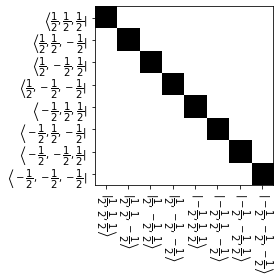

In [4]:
L.H[0].plot(mode='spy')

Likewise, if we have a diagonal Hamiltonian and no spinning, the equilibrium density operator also yields zero with the Liouvillian. 

In [5]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')


In [6]:
np.abs(L[0].L(0)@L.rho_eq()).max()

5.551115123125782702e-17

In [7]:
np.abs(L[0].L(0)@L.rho_eq(step=0)).max()

0.068951688013723672066

On the other hand, if we start to spin, then the thermal equilibrium is modulated throughout the rotor period. The thermalization matrix is adjusted to yield the mean thermal equilibrium ("step" is omitted). Then, the first calculation yields zero. If we go to a particular step (step=0), then we no longer get zero. So, thermalization yields the correct mean value, but not the correct value at individual steps in the rotor period.

In [3]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
# ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('Thermal')

In [4]:
np.abs(L[0].L(0)@L[0].rho_eq(step=0)).max()

6.1048388588271179233e-14

In [5]:
np.abs(L[0].L(10)@L[0].rho_eq(step=10)).max()

1.0783041142264560631e-13

In [6]:
np.abs(L[0].L(0)@L[0].rho_eq(step=10)).max()

0.0129807746377792743164

A different thermalization routine ('Thermal' instead of 'recovery'), on the other hand, gets the correct thermal equilibrium at all steps in the rotor period. It obviously doesn't work if we mis-match the equilibrium step with the Liouvillian step. This method, however, poses some challenges for our Parallel Manager, so it is often not actually being used. 

In [7]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [8]:
np.abs(L[0].L(0)@L[0].rho_eq(step=0)).max()

1.4762677062825854247

<AxesSubplot:>

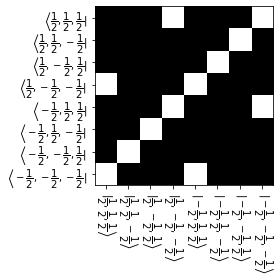

In [9]:
L.H[0].plot(mode='spy')

Neither method works correctly if the Hamiltonian is not diagonal. This is because our relaxation is implemented assuming a near-diagonal Hamiltonian, whereas the true relaxation behavior should occur for the eigenstates of the Hamiltonian. 

In [12]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
_=L.add_relax('T1',i=2,T1=3)
_=L.add_relax('Thermal')

In [13]:
np.abs(L[0].L(0)@L[0].rho_eq(step=0)).max()

1.4726787460715317974

Removing thermalization entirely also does not help (it is curiously, worse)

In [14]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=0,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
_=L.add_relax('T1',i=2,T1=3)
_=L.add_relax('Thermal')

In [121]:
np.abs(L[0].L(0)@L[0].rho_eq(step=0)).max()

1.6358597191546238

The situation from above does not improve by going back to a static Hamiltonian.

## Eigenvalues of the propagator
The next question is under what conditions do the eigenvalues of the propagator exceed 1, which in general should not occur.

In [3]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=0,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [4]:
np.real(np.linalg.eig(L.U(Dt,calc_now=True)[0])[0]).max()

0.9999999999921652

For the static case, we have no problem with the eigenvalues of the propagator

In [5]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [6]:
np.real(np.linalg.eig(L.U(Dt)[0])[0]).max()

1.000000000002578

In the rotating frame, we seem to not have any problem getting eigenvalues less than/equal to 1.

In [7]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [8]:
np.real(np.linalg.eig(L.U(Dt)[0])[0]).max()

6.40660622888703

In the lab frame, however, we no longer get eigenvalues of 1

In [9]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=0,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
_=L.add_relax('recovery')

In [10]:
np.real(np.linalg.eig(L.U(Dt)[0])[0]).max()

1.000000050672564

Going to the static case also appears to repair the problem

In [11]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=True,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
_=L.add_relax('T1',i=2,T1=3)
_=L.add_relax('Thermal')

In [12]:
np.real(np.linalg.eig(L.U(Dt)[0])[0]).max()

0.9999999985667922

Using the "Thermal" option puts eigenvalues back to 1 or less. I'm not convinced this is fixing it. I think maybe Thermal just isn't running.

In [13]:
from scipy.linalg import expm
dt=L.dt
U=L.Ueye()[0]
for k in range(ex.n_gamma):dd
    U=expm(L[0].L(k)*dt)@U
np.real(np.linalg.eig(U)[0]).max()

0.9999999985667922

Here, Thermal is really being used, and indeed it works

## Is "Thermal" really running?

State-space reduction: 64->8


<AxesSubplot:xlabel='t / s', ylabel='<$^{1}H_z$>'>

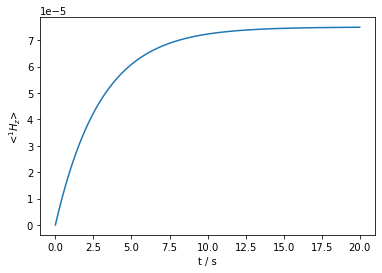

In [15]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=False,vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
# ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
# ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
# ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
L.add_relax('Thermal')
    
seq=L.Sequence()
rho=sl.Rho('zero','1Hz')
rho.DetProp(seq,n=100000)
rho.plot(axis='s')

I'm pretty sure Lthermal is somehow only being applied part of the time. So we need to fix that. Still, when it is applied correctly, it seems to correct the eigenvalues